In [1]:
#files
import sys
#from os import listdir
sys.path.append('../data')
sys.path.append('../Librerias')
#from os.path import isfile, join

#own libs
import utils
import caract as dc
import dataset as ds
from RNN_model import SimpleRNN
from lstm_models import LSTM
import utils_2 as ut2
from traindata import trainData



#data and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

sns.set_style("darkgrid")


import numpy as np
import random
import os, errno
from tqdm import tqdm

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as data_utils


np.random.seed(seed=77)
torch.manual_seed(77)

c:\Users\consu\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
fpath = "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/low/"
#fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/low/"
fname = "file1_080124.mat"
#cutoff = [8/1000, 11/1000]

data = trainData(fpath, fname, 'Amplitude')
train, val, test = data.split_data('Amplitude')

In [ ]:
# sub sampleo

train = utils.subsample(train, 2)
val = utils.subsample(val, 2)
test = utils.subsample(test, 2)

## **scaler**

In [3]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.reshape(-1, 1))
val_scaled = scaler.transform(val.reshape(-1, 1))
test_scaled = scaler.transform(test.reshape(-1, 1))

In [4]:
x_train, y_train = ut2.create_sequences(train_scaled[:10000], 1000, 1)
x_val, y_val = ut2.create_sequences(val_scaled[:5000], 1000, 1)
x_test, y_test = ut2.create_sequences(test_scaled[:3000], 1000, 1)

In [5]:
'''x_train, y_train = ut2.create_sequences(train_scaled[:200000], 1000, 50)
x_val, y_val = ut2.create_sequences(val_scaled[:45000], 1000, 50)
x_test, y_test = ut2.create_sequences(test_scaled[:45000], 1000, 50)

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape'''

'x_train, y_train = ut2.create_sequences(train_scaled[:200000], 1000, 50)\nx_val, y_val = ut2.create_sequences(val_scaled[:45000], 1000, 50)\nx_test, y_test = ut2.create_sequences(test_scaled[:45000], 1000, 50)\n\nx_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape'

In [6]:
x_train = torch.from_numpy(x_train.astype(np.float32)).squeeze()
y_train = torch.from_numpy(y_train.astype(np.float32)).squeeze()
x_val = torch.from_numpy(x_val.astype(np.float32)).squeeze()
y_val = torch.from_numpy(y_val.astype(np.float32)).squeeze()
x_test = torch.from_numpy(x_test.astype(np.float32)).squeeze()
y_test = torch.from_numpy(y_test.astype(np.float32)).squeeze()

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

(torch.Size([9000, 1000]),
 torch.Size([9000]),
 torch.Size([4000, 1000]),
 torch.Size([4000]),
 torch.Size([2000, 1000]),
 torch.Size([2000]))

## **Single Step**

In [7]:
class GRU(nn.Module):
    def __init__(self,in_dim, hid_dim, out_dim, num_layers):
        super().__init__()
        
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        self.gru = nn.GRU(self.in_dim, self.hid_dim, self.layer, batch_first=True)
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):
        
        # initalize the hidden layers
        h0 = torch.zeros(self.layer, self.hid_dim)
        
        out, _ = self.gru(x,h0)
        out = self.fc(out)
        return out

In [8]:
in_size = x_train.shape[-1]
out_size = 1
hid_size = x_train.shape[-1]//2
num_layers = 2


model = GRU(in_size,hid_size,out_size, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [9]:
train_loss, test_loss = ut2.simpleTrain_model(model,
                                            criterion,
                                            optimizer,
                                            x_train,
                                            x_val,
                                            y_train,
                                            y_val,
                                            epochs=10)

 20%|██        | 2/10 [04:21<17:26, 130.87s/it]


Training Interrupted by user


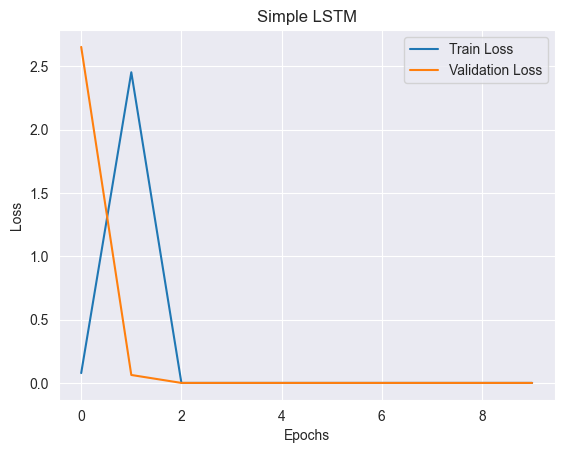

In [10]:
ut2.plot_loss(train_loss, test_loss, 'Simple LSTM')

In [14]:
val_loss = np.asanyarray(test_loss)
train_loss = np.asanyarray(train_loss)
np.savetxt("train_lossSimpleGRU.csv", train_loss, delimiter=",")
np.savetxt("val_lossSimpleGRU.csv", val_loss, delimiter=",")

## **test predictions**

In [11]:
test_pred = ut2.rollingWindowPrediction(model, x_test, steps = 50)

100%|██████████| 2000/2000 [04:53<00:00,  6.82it/s]


In [12]:
np.asarray(test_pred).shape

(2000, 50)

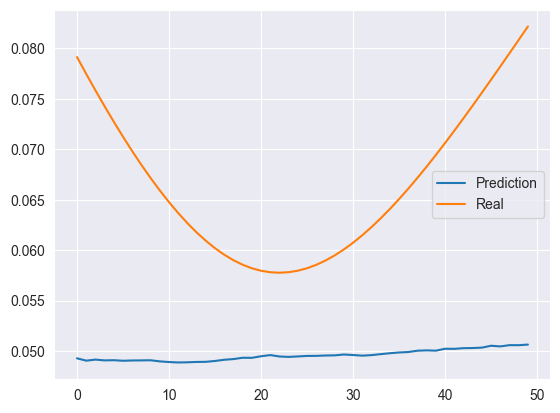

In [13]:
i = 65

plt.plot(test_pred[i], label='Prediction')
plt.plot(y_test[i:i+50].detach().numpy(), label='Real')
plt.legend()
plt.show()